In [1]:
import torch
from torch.distributions import normal
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.utils import save_image

from torchvision import datasets

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torchvision.datasets.MNIST('./',download = True)

100%|██████████| 9912422/9912422 [00:01<00:00, 5181635.33it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28739191.89it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5273425.13it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1801638.81it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

In [2]:
Transform = transforms.ToTensor()
train = datasets.MNIST(root='./', train = True, download = False, transform = Transform)
train

#images, ground_truth = torch.load('MNIST/processed/training.pt')

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
test = datasets.MNIST(root='./', train = False, download = False, transform = Transform)
test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: ToTensor()

torch.Size([1, 28, 28])
5
<class 'torch.Tensor'>
5
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      

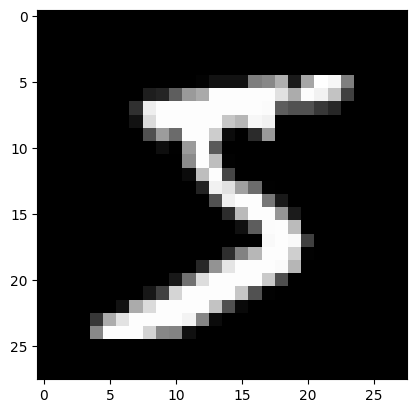

In [7]:
image, label = train[0]
print(image.shape) # The one means there's only one channel
print(label)
plt.imshow(image.reshape((28,28)), cmap='gray')
#print(len(train))
images = [None] * len(train)
labels = [None] * len(train)
for i in range(len(train)):
    images[i] = train[i][0]
    labels[i] = train[i][1]
print(type(images[0]))
print(labels[0])
print(images[0])

8


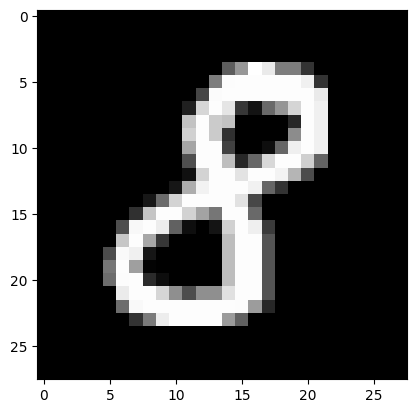

In [27]:
# Alter the image index to check the label and image.
image_index = 225
print(train[image_index][1])
plt.imshow(train[image_index][0].reshape((28,28)), cmap='gray')

In [37]:
from torch.utils.data import Dataset
class MNISTDataset(Dataset):
    """
    MAP-style. __getitem__ and __len__ methods need to be implemented.
    """
    def __init__(self, path, train): # train is a boolean
        Transform = transforms.ToTensor()
        data = datasets.MNIST(root=path, train = train, download = False, transform = Transform)
        self.images = [None] * len(data) #Holds the image pixel array
        self.labels = [None] * len(data) #Holds the number label
        for i in range(len(data)):
            self.images[i] = data[i][0]
            self.labels[i] = data[i][1]

    def __getitem__(self, index):
        x = self.images[index].float()
        x = torch.Tensor(x)
        x = torch.flatten(x) # flatten the image from a 28 x 28 to a 784 1-dimensional tensor
        return x

    # returns the length of the dataset
    def __len__(self):
        return len(self.labels)

In [38]:
# Formally make the datasets
train_dataset = MNISTDataset('./', True)
test_dataset = MNISTDataset('./', False)

print("Train dataset length: ", len(train_dataset))
print("Test dataset length: ", len(test_dataset))

Train dataset length:  60000
Test dataset length:  10000


In [39]:
train_dataset[15].shape # Tests to see if getitem works. __getitem__ runs when indexing the dataset

torch.Size([784])

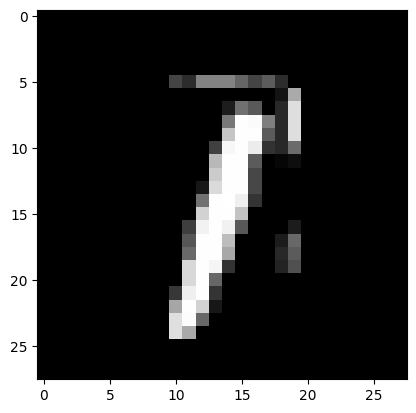

In [42]:
plt.imshow(train_dataset[67].numpy().reshape((28, 28)), cmap='gray')

Autoencoder time

In [43]:
class AutoEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim = 128):
        super().__init__()

        # 2 layers for the encoder
        self.encoder_l1 = nn.Linear(in_features=input_shape, out_features=latent_dim)
        self.encoder_l2 = nn.Linear(in_features=latent_dim, out_features=latent_dim)

        # decoder
        self.decoder_l1 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
        self.decoder_l2 = nn.Linear(in_features=latent_dim, out_features=input_shape)
    
    def forward(self, x):
        '''
        x is the input data
        returns the reconstruction
        '''
        latent = self.run_encoder(x)
        x_hat = self.run_decoder(latent)
        return x_hat

    def run_encoder(self, x):
        output = F.relu(self.encoder_l1(x)) # relu adds non linearity
        latent = F.relu(self.encoder_l2(output)) # results in the latent vector
        return latent

    def run_decoder(self, latent):
        output = F.relu(self.decoder_l1(latent))
        x_hat = F.relu(self.decoder_l2(output))
        return x_hat

In [45]:
train_dataset = MNISTDataset('./', True)
test_dataset = MNISTDataset('./', False)

image_shape = train_dataset[0].shape[0] # Gets the shape of an image from the dataset. '.shape' has a [0] to get the integer from the tensor object
print(image_shape)

model = AutoEncoder(input_shape = image_shape)
#model.cuda()

784


In [47]:
model.train() # Set to train() mode. There's also an eval() mode.

AutoEncoder(
  (encoder_l1): Linear(in_features=784, out_features=128, bias=True)
  (encoder_l2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l1): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l2): Linear(in_features=128, out_features=784, bias=True)
)

In [ ]:
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=128, #number of training samples to load in at a time
                                            shuffle=True) # Shuffle the data beforehand
mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 100

for epoch in range(n_epochs):
    loss = 0
    #Batch_features is each training batch. Here it's of the shape (128, 784).
    for batch_features in train_loader:
        batch_features = batch_features.cuda()

        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(batch_features)

        # compute the reconstruction loss of the training data
        train_loss = mse(outputs, batch_features)

        #compute accumulated gradients
        train_loss.backward()
